<a href="https://www.spe.org/events/en/2022/conference/22apog/asia-pacific-oil-and-gas-conference-and-exhibition.html"><img src = "https://www.spe.org/binaries/content/gallery/specms/speevents/organization-logos/spe-logo-2020.png" width = 200> 

<h1 align=center><font size = 5>Prediction of Recovery Factor using Machine Learning Methods</font></h1>

<h1 align=center><font size = 4> Munish Kumar, Kannapan Swaminathan</font></h1>
<h1 align=center><font size = 4> Part 4a: Simplified Experiments</font></h1>
<h1 align=center><font size = 3> ERCE 2022 </font></h1>

###### References

1. https://www.kaggle.com/code/kkhandekar/an-introduction-to-pycaret/notebook.
2. https://towardsdatascience.com/5-things-you-dont-know-about-pycaret-528db0436eec
3. https://www.dataquest.io/blog/understanding-regression-error-metrics/ 
4. https://www.analyticsvidhya.com/blog/2021/07/automl-using-pycaret-with-a-regression-use-case/
5. https://www.datacamp.com/community/tutorials/guide-for-automating-ml-workflows-using-pycaret
6. https://pycaret.readthedocs.io/en/latest/api/regression.html
7. http://www.pycaret.org/tutorials/html/REG102.html
8. https://githubhelp.com/ray-project/tune-sklearn

## Check PyCaret Version

In [1]:
from pycaret.utils import version

In [2]:
version()

'2.3.6'

#### Libraries

In [3]:
# Only install the following libraries if you dont have it, otherwise leave it commented out

#!conda install -c anaconda natsort --yes
#!conda install -c anaconda xlrd --yes

#!pip install natsort --user
#!pip install xlrd --user
#!pip install pycaret[full] --user
#!pip install mlflow --user
#!pip install tune-sklearn ray[tune] --user
#!pip install optuna -- user
#!pip install hyperopt --user
#!pip install redis --user

# General Libraries
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import NullFormatter
import time
import re
import requests
import pickle
import seaborn as sns
import os
import glob
import sys
from natsort import natsorted
sns.set()

import plotly.graph_objects as go
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

# Sklearn Liraries
from sklearn import preprocessing

import datetime
from datetime import timedelta, date 
start = time.time()
%matplotlib inline

import ray
from ray import tune

# Forces the print statement to show everything and not truncate
# np.set_printoptions(threshold=sys.maxsize) 
print('Libraries imported')

Libraries imported


In [4]:
#Receive Data
#dir_name = r'C:\Users\kswaminathan\OneDrive\01_KannaLibrary\15_Analogs'
#dir_name = r'C:\Users\mkumar\Documents\GitHub\@Papers\SPE2022\Final'
dir_name = r'C:\Users\mkumar\Documents\GitHub\@Papers\SPE2022\Final\1_TORIS_MODEL'
filename_suffix = 'csv'

##### Read in the data 

In [5]:
skiprows = 0
#Means read in the ',' as thousand seperator. Also drops all columns which are unnamed.
df = pd.read_excel("dftorisv2.xlsx", thousands=',', skiprows = skiprows)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')] 
df.head()

,Lithology Code,Well Spacing,Net Pay Pay,Gross Pay,Porosity,Swi,Oil FVFi,Temp,Permeability,API Gravity,...,Fractured Faulted,Shale Breaks,Major Gas Cap,Geologic Play,Deposition System,Diagenetic Overprint,Structural Comp,Heterogeniety,Trap Type,URF
0,1,120.0,320.0,600.0,14.0,40.0000,1.586,153,10.0,41.0,...,0,0,0,303,132,1,10,1,2,0.352836
1,1,160.0,100.0,160.0,18.1,35.0000,1.230,163,65.0,35.6,...,0,0,0,303,132,1,10,1,2,0.321570
2,1,160.0,100.0,300.0,15.7,51.6333,1.190,185,102.0,32.9,...,0,1,0,303,132,1,10,1,2,0.277514
3,1,80.0,350.0,1400.0,13.0,30.0000,1.230,153,3.0,35.0,...,1,1,0,303,131,1,10,1,2,0.380000
4,1,160.0,194.0,550.0,23.0,35.0000,1.380,200,450.0,27.0,...,1,1,1,302,131,7,10,1,3,0.425909


# Plot as Heat map to check for highly correlated variables
plt.figure(figsize=(15, 15))
ax = sns.heatmap(df.corr(), annot=True, fmt=".2f")

In observing the heat map above, I define highly correlated variables as having collinearity coeeficients of > 0.7. There was no highly correlated values

##### Convert to float - to ensure it is a numerical feature

In [6]:
df_drop = df.copy()
df_drop = df_drop.astype(float)

# Confirm properties of final dataframe
print(len(df_drop))
print(df_drop.info())
print(df_drop.describe(include='all'))
print(df_drop.columns.values)

449
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 449 entries, 0 to 448
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Lithology Code        449 non-null    float64
 1   Well Spacing          449 non-null    float64
 2   Net Pay Pay           449 non-null    float64
 3   Gross Pay             449 non-null    float64
 4   Porosity              449 non-null    float64
 5   Swi                   449 non-null    float64
 6   Oil FVFi              449 non-null    float64
 7   Temp                  449 non-null    float64
 8   Permeability          449 non-null    float64
 9   API Gravity           449 non-null    float64
 10  Viscosity             449 non-null    float64
 11  OOIP                  449 non-null    float64
 12  Initial GOR           449 non-null    float64
 13  Pressure Initial      449 non-null    float64
 14  Fractured Faulted     449 non-null    float64
 15  Shale Breaks       

Final Data set has 450 rows and 24 columns.

### Train, Validation, and Test Split

# Creates a mask where values that are true go into the training/test set
# Note that I done it so that the random number is predictable

msk = np.random.seed(0)
msk = np.random.rand(len(df_drop))<0.8

raw_train_validate_set = df_drop[msk]
raw_test_set = df_drop[~msk]

print(raw_train_validate_set.shape)
print(raw_test_set.shape)

raw_train_validate_set.to_excel(r'dfssoil.xlsx', index = False, header=True)
raw_test_set.to_excel(r'BlindTest_SSOIL.xlsx', index = False, header=True)

We split the data set 80-20 into a "train-validate" set and a "test" set. The test set is external asn will never be seen by the model.

## 1. Pycaret Implementation

Pycaret will be used in the machine learning portion. Pycaret is a low-code machine learning library in Python that automates machine learning workflows. One of its key benefits is its ability to run a large number of differnt machine learning algorithms, but with only a few lines of code

In [7]:
skiprows = 0
#Means read in the ',' as thousand seperator. Also drops all columns which are unnamed.
df = pd.read_excel("dfssoil.xlsx", thousands=',', skiprows = skiprows)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')] 
df.head()

,Lithology Code,Well Spacing,Net Pay Pay,Gross Pay,Porosity,Swi,Oil FVFi,Temp,Permeability,API Gravity,...,Fractured Faulted,Shale Breaks,Major Gas Cap,Geologic Play,Deposition System,Diagenetic Overprint,Structural Comp,Heterogeniety,Trap Type,URF
0,1,120.0,320.0,600.0,14.0,40.0000,1.586,153,10.0,41.0,...,0,0,0,303,132,1,10,1,2,0.352836
1,1,160.0,100.0,160.0,18.1,35.0000,1.230,163,65.0,35.6,...,0,0,0,303,132,1,10,1,2,0.321570
2,1,160.0,100.0,300.0,15.7,51.6333,1.190,185,102.0,32.9,...,0,1,0,303,132,1,10,1,2,0.277514
3,1,80.0,350.0,1400.0,13.0,30.0000,1.230,153,3.0,35.0,...,1,1,0,303,131,1,10,1,2,0.380000
4,1,160.0,194.0,550.0,23.0,35.0000,1.380,200,450.0,27.0,...,1,1,1,302,131,7,10,1,3,0.425909


In [8]:
from pycaret.regression import *

#Create a copy
model_df = df_drop.copy()
target = 'URF'

# no resampling
clf_none = setup(
            data=model_df,
            target=target,
            session_id=42,
            normalize=True,
            transformation = True,
            ignore_low_variance=True,
            remove_outliers = True, outliers_threshold = 0.2,
            remove_multicollinearity = True, #multicollinearity_threshold = 0.6,
            train_size=0.7)

,Description,Value
0,session_id,42
1,Target,URF
2,Original Data,"(449, 24)"
3,Missing Values,False
4,Numeric Features,21
5,Categorical Features,2
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(251, 23)"


In [9]:
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.0918,0.0144,0.1187,0.1014,0.0877,0.3486,0.0320
rf,Random Forest Regressor,0.0918,0.0143,0.1188,0.1001,0.0879,0.3529,0.0410
ada,AdaBoost Regressor,0.0917,0.0143,0.1192,0.0947,0.0883,0.3561,0.0130
catboost,CatBoost Regressor,0.0905,0.0144,0.1193,0.0912,0.0883,0.3501,0.5610
br,Bayesian Ridge,0.0942,0.0146,0.1204,0.0827,0.0891,0.3644,0.0040
gbr,Gradient Boosting Regressor,0.0923,0.0146,0.1199,0.0798,0.0887,0.3499,0.0130
ridge,Ridge Regression,0.0966,0.0151,0.1225,0.0467,0.0909,0.3657,0.0040
lr,Linear Regression,0.0968,0.0152,0.1227,0.0430,0.0910,0.3660,0.3770
lar,Least Angle Regression,0.0974,0.0153,0.1232,0.0339,0.0915,0.3687,0.0040
knn,K Neighbors Regressor,0.0958,0.0154,0.1237,0.0237,0.0912,0.3532,0.0050


top3 = compare_models(include=['rf', 'catboost', 'knn'], fold = 10, sort='MAE')

There is a performance improvement in going from 5 folds to 10 folds for all 3 models. To keep computation time reasonable, folds is kept at 10.

----------------------------------------------------------------------------------------------------------------------------

## 3. Optimisation

### a. Tune the Model

In [10]:
tuned_models = []

In [11]:
rf = create_model('rf', fold = 10)
rf = tune_model(rf, 
                optimize = 'RMSE', 
                n_iter = 50, 
                choose_better = True, 
                 #search_library = "tune-sklearn", 
                 #search_algorithm="Hyperopt",
                 #search_algorithm="Optuna",
                 #search_algorithm="bayesian",
                )
tuned_models.append(rf)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0737,0.0086,0.0926,0.1272,0.0697,0.2627
1,0.1148,0.0180,0.1341,0.2046,0.1002,0.4765
2,0.0963,0.0158,0.1256,0.1191,0.0914,0.3617
3,0.0968,0.0141,0.1186,-0.0109,0.0919,0.5103
4,0.0841,0.0137,0.1169,0.0860,0.0845,0.2804
5,0.1064,0.0167,0.1293,-0.0477,0.0940,0.3408
6,0.0904,0.0140,0.1183,0.1897,0.0879,0.3709
7,0.0804,0.0103,0.1017,0.3166,0.0761,0.2968
8,0.0899,0.0149,0.1221,0.0470,0.0922,0.4330
9,0.0887,0.0153,0.1236,0.0935,0.0874,0.2467


knn = create_model('knn', fold = 10)
et = tune_model(knn, 
                optimize = 'RMSE', 
                n_iter = 50, 
                choose_better = True, 
                 #search_library = "tune-sklearn", 
                 #search_algorithm="Hyperopt",
                 #search_algorithm="Optuna",
                 #search_algorithm="bayesian",
                )
tuned_models.append(knn)

catboost = create_model('catboost', fold = 10)
catboost = tune_model(catboost, 
                optimize = 'RMSE', 
                n_iter = 50, 
                choose_better = True, 
                 #search_library = "tune-sklearn", 
                 #search_algorithm="Hyperopt",
                 #search_algorithm="Optuna",
                 #search_algorithm="bayesian",
                )
tuned_models.append(catboost)

## 5. Finalise the model

In [12]:
final_et = finalize_model(rf)
#final_et = finalize_model(et)

### Plots to analyse Model

In [13]:
model = final_et
predict_model(model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.0797,0.0099,0.0995,0.4153,0.0732,0.3106


,Lithology Code,Well Spacing,Net Pay Pay,Gross Pay,Porosity,Swi,Oil FVFi,Temp,Permeability,API Gravity,...,Geologic Play,Deposition System,Diagenetic Overprint,Structural Comp,Heterogeniety,Trap Type,Fractured Faulted_1.0,Shale Breaks_1.0,URF,Label
0,-0.752517,0.602711,-0.931360,-0.997380,-0.262988,1.342416,0.615049,-0.184962,-0.777062,0.917657,...,-1.150668,-0.067872,1.783713,-0.455652,-0.686846,-1.673975,0.0,0.0,0.250000,0.282769
1,1.276402,1.402515,-0.689311,-1.041017,-1.308222,-0.189573,1.074563,0.301265,-0.279372,0.917657,...,-1.154283,1.625201,-0.740646,-0.455652,-0.686846,-1.673975,0.0,1.0,0.504560,0.385485
2,-0.752517,-1.186079,1.278859,0.794820,-0.401206,0.987307,0.949207,1.465668,-0.654778,-0.303106,...,0.008801,-0.041225,-0.740646,-0.455652,-0.686846,-0.414861,1.0,1.0,0.380000,0.347480
3,-0.752517,-0.294680,-0.718522,-1.118747,-0.572322,-0.784482,0.628467,0.158020,-0.704353,0.058473,...,-1.168779,-0.859795,-0.740646,-0.455652,-0.686846,-1.673975,0.0,0.0,0.290000,0.370909
4,-0.752517,-1.344908,1.835742,1.931956,1.700929,-0.521203,-1.333851,-0.328036,1.276756,-1.408754,...,-0.005210,-0.041225,-0.740646,2.217926,1.694416,-0.414861,1.0,1.0,0.650000,0.400928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,-0.752517,-1.263619,2.066868,1.931956,0.245035,0.617352,0.541186,0.685477,-0.172917,-0.519274,...,0.008801,-0.041225,-0.740646,-0.455652,-0.686846,-0.414861,1.0,1.0,0.370000,0.355038
131,-0.752517,-1.344908,1.401888,-0.005199,1.616491,-1.102301,-1.333851,0.005136,1.902584,-2.366800,...,0.018079,0.217763,1.826869,2.127502,1.694416,-0.414861,0.0,0.0,0.060521,0.242272
132,-0.752517,-0.294680,-1.380985,-1.314870,1.265078,0.227689,-0.845153,-0.328036,1.757420,-1.582771,...,1.686849,-0.889504,-0.740646,-0.455652,-0.686846,-0.414861,1.0,0.0,0.274000,0.341481
133,-0.752517,-0.810540,-1.474872,-1.279495,-0.839059,-1.102301,-0.036777,-1.443602,-0.757408,1.404480,...,1.295368,-0.889504,-0.740646,-0.455652,-0.686846,1.153353,0.0,1.0,0.422148,0.361192


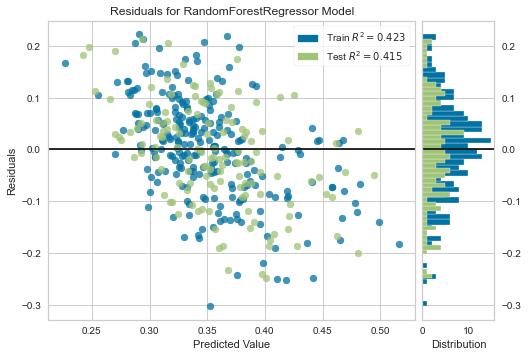

In [14]:
plot_model(model)

## 6. Blind Test

In [15]:
dfblind = pd.read_excel("BlindTest_SSOIL.xlsx", thousands=',', skiprows = skiprows)
#dfblind = dfblind.loc[:, ~df.columns.str.contains('^Unnamed')] 
dfblind.head()

,Lithology Code,Well Spacing,Net Pay Pay,Gross Pay,Porosity,Swi,Oil FVFi,Temp,Permeability,API Gravity,...,Fractured Faulted,Shale Breaks,Major Gas Cap,Geologic Play,Deposition System,Diagenetic Overprint,Structural Comp,Heterogeniety,Trap Type,URF
0,1,20.0000,8.6,12.0,30.0,32.0,1.100,118,1200.0,17.0,...,1,0,0,2407,151,1,10,1,2,0.274000
1,1,10.0000,10.0,60.0,25.0,40.0,1.100,110,1500.0,34.0,...,0,1,0,2407,151,1,10,1,1,0.360000
2,1,20.0000,11.0,110.0,28.0,25.0,1.060,125,1500.0,20.0,...,0,1,1,2407,151,1,10,1,2,0.320000
3,1,10.0000,190.0,480.0,27.0,22.0,1.140,146,430.0,23.5,...,0,0,0,418,181,1,10,1,2,0.258000
4,1,2.3662,556.0,1500.0,25.5,20.0,1.311,190,58.0,27.7,...,0,1,0,414,181,1,30,3,2,0.309771


In [16]:
BlindPredict = predict_model(final_et, data=dfblind, round=2)

In [17]:
BlindPredict

,Lithology Code,Well Spacing,Net Pay Pay,Gross Pay,Porosity,Swi,Oil FVFi,Temp,Permeability,API Gravity,...,Shale Breaks,Major Gas Cap,Geologic Play,Deposition System,Diagenetic Overprint,Structural Comp,Heterogeniety,Trap Type,URF,Label
0,1,20.0000,8.6,12.0,30.0,32.0,1.100,118,1200.0,17.0,...,0,0,2407,151,1,10,1,2,0.274000,0.341481
1,1,10.0000,10.0,60.0,25.0,40.0,1.100,110,1500.0,34.0,...,1,0,2407,151,1,10,1,1,0.360000,0.397176
2,1,20.0000,11.0,110.0,28.0,25.0,1.060,125,1500.0,20.0,...,1,1,2407,151,1,10,1,2,0.320000,0.385574
3,1,10.0000,190.0,480.0,27.0,22.0,1.140,146,430.0,23.5,...,0,0,418,181,1,10,1,2,0.258000,0.332076
4,1,2.3662,556.0,1500.0,25.5,20.0,1.311,190,58.0,27.7,...,1,0,414,181,1,30,3,2,0.309771,0.371445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,1,40.0000,40.0,520.0,14.7,21.0,1.700,140,34.0,47.0,...,0,1,704,110,1,10,1,1,0.470000,0.393697
81,1,10.0000,71.0,100.0,19.0,33.5,1.130,100,52.0,37.0,...,0,0,831,151,1,31,1,2,0.470000,0.382478
82,1,20.0000,150.0,250.0,10.3,10.0,1.126,165,20.0,34.0,...,0,0,825,110,1,31,1,2,0.450000,0.397385
83,1,20.0000,105.0,300.0,16.3,11.5,1.050,125,190.0,25.0,...,0,0,825,110,1,31,1,2,0.400000,0.382866


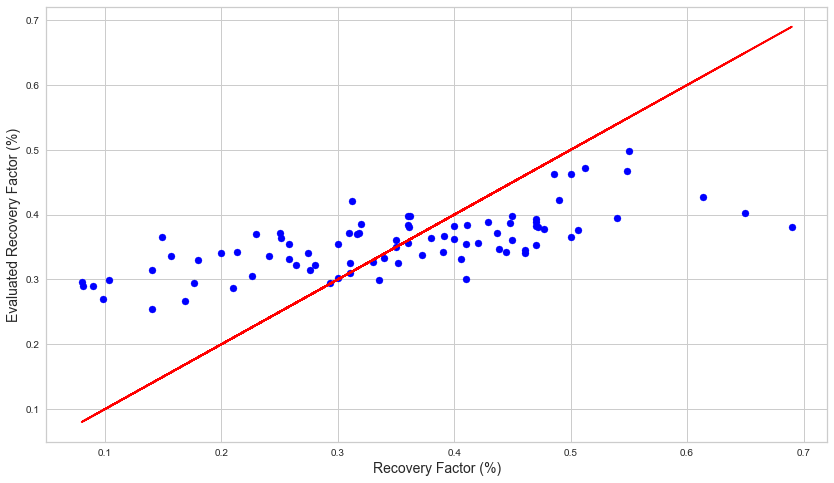

In [18]:
a = BlindPredict['URF']
b = BlindPredict['Label']

plt.figure(figsize=(14, 8))
plt.scatter(a, b, color='blue')
plt.plot(a, a, color = 'red', label = 'x=y')
plt.xlabel("Recovery Factor (%)", size=14)
plt.ylabel("Evaluated Recovery Factor (%)", size=14)

#plt.tight_layout()
plt.show()

In [19]:
count = 'Completed Process'
elapsed = (time.time() - start)
print ("%s in %s seconds" % (count,elapsed))

Completed Process in 43.260403633117676 seconds
